In [1]:
import pandas as pd
import geopandas as gpd
# Load the TensorBoard notebook extension
%load_ext tensorboard

import os
from dataloader import fishingDataLoader
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
def emptyLog():
    folder = "logs"
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))
    log_dir = f"{folder}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=False,
        update_freq="epoch",
    )

In [5]:
#emptyLog()

In [3]:
def loadFishingData():
    loader = fishingDataLoader()
    data = loader.loadAllTrainingData()
    return data.reset_index(drop=True)

def loadIresData():
    data = pd.read_csv("test/iris_original.csv")
    return data

def createHotVector(y):
    if isinstance(y, pd.DataFrame):
        if len(lables.columns) == 1: # check if Datafram has only one colum
            return -1
        
        
        y_vector = np_utils.to_categorical(y.to_numpy())
    else:
        y_vector = np_utils.to_categorical(y)
    return pd.DataFrame(y_vector)

def cleanrows(df: pd.DataFrame):
    old_count_rows = df.shape[0]
    df = df.dropna()
    new_conut_rows = df.shape[0]
    print(f"deletet {old_count_rows-new_conut_rows} rows")
    return df

def generateClassWeightsFromHotVektor(lable: pd.DataFrame):
    n_samples, n_classes = lable.shape
    feature_index, idx, count = tf.unique_with_counts(tf.argmax(lable,axis=1))
    class_weight = dict()
    
    for key, samples_of_class in zip(feature_index.numpy(),count.numpy()):
        score = n_samples/(n_classes*samples_of_class)
        class_weight[key] = score 
    return class_weight
    

def normalizeColums(df: pd.DataFrame, name_of_cols):
    df[name_of_cols] = df[name_of_cols]/ df[name_of_cols].abs().max()
    return df
    
def printFeatureDistribution(features):
    if features.shape[-1] != 1:
        features = tf.argmax(features,axis=1)
    
    if isinstance(features, pd.DataFrame):
        features = features.to_numpy()
    feature_index, idx, count = tf.unique_with_counts(features)
    feature_index = feature_index.numpy()
    count = count.numpy()
    percent = tf.round((count/ sum(count))*10000)/100
    d = {
        "amount": count,
        "percent %": percent
    }
    dist = pd.DataFrame(d, index=feature_index)
    print(dist)
    
def prepareDataset(raw_data: pd.DataFrame, testSize = 0.2):
    
    raw_data = cleanrows(raw_data) #Del row with nan values
    
    nameOfFeatureCols = raw_data.columns[:-1]
    number_coloums = len(raw_data.columns)
    nameOfTargetCol = raw_data.columns[-1]
    raw_data = pd.get_dummies(raw_data, columns=[nameOfTargetCol], dtype=float)
    
    target_colums = len(raw_data.columns)-number_coloums+1 # how many target coloums exists
    
    train_data, val_data = train_test_split(raw_data, test_size=testSize)
    
    train_features, train_lable = train_data.iloc[:,:-target_colums], train_data.iloc[:,-target_colums:]
    val_features, val_lable = val_data.iloc[:,:-target_colums], val_data.iloc[:,-target_colums:]
    

    return train_features, train_lable, val_features, val_lable

def turnUnixTimeToDate(date: int):
    return datetime.datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S')


In [4]:
#raw_data = loadFishingData()

train_features, train_lables, val_features, val_lables = prepareDataset(loadFishingData(),testSize=0.2)


TARGETS = len(train_lables.columns)
INPUTS = train_features.shape[-1]

                 mmsi     timestamp  distance_from_shore  distance_from_port  \
0        1.252340e+12  1.325376e+09             0.000000             0.00000   
1        1.252340e+12  1.325378e+09             0.000000             0.00000   
2        1.252340e+12  1.325379e+09             0.000000             0.00000   
3        1.252340e+12  1.325380e+09             0.000000             0.00000   
4        1.252340e+12  1.325381e+09             0.000000             0.00000   
...               ...           ...                  ...                 ...   
1545318  4.393595e+13  1.480030e+09        132057.359375        507208.40625   
1545319  4.393595e+13  1.480030e+09        132057.359375        507208.40625   
1545320  4.393595e+13  1.480030e+09        132057.359375        507208.40625   
1545321  4.393595e+13  1.480030e+09        132057.359375        507208.40625   
1545322  4.393595e+13  1.480030e+09        132030.843750        506601.81250   

         speed      course        lat  

In [10]:
loader = fishingDataLoader()
print(loader.file_list)
loader.genSmalerDataset(sample=60000)

['trawlers.csv', 'drifting_longlines.csv', 'trollers.csv', 'unknown.csv', 'pole_and_line.csv', 'fixed_gear.csv', 'purse_seines.csv']


AttributeError: 'fishingDataLoader' object has no attribute 'genSmalerDataset'

In [8]:
groups = train_features.groupby('mmsi')
print(type(groups))
for name,group in groups:
    print(name)

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
1252339803566.0
5020143137211.0
5145483253513.0
5601266154050.0
7572518792420.0
8681844482850.0
9924005022437.0
10759394346704.0
10880510825243.0
11170005450471.0
12639560807591.0
16508054338972.0
18199244904065.0
18483455048454.0
19859547683322.0
20001834541437.0
21232708893780.0
23406746127304.0
23593130178765.0
23770783250938.0
26616040923734.0
27932326533321.0
28144259049658.0
30054937091173.0
30373804074051.0
30581813007233.0
31865679879784.0
32225346417081.0
33266086194351.0
34911701098431.0
36212632719018.0
36427802545466.0
37908995999986.0
38322969102051.0
38992105566132.0
39005622580143.0
39859406485734.0
40834114543542.0
40976637345731.0
41941786536935.0
42314208291274.0
43935946737362.0
44009123736191.0
47334168288729.0
48455039594066.0
48939529147579.0
49160289345306.0
49534994750419.0
51101297206144.0
51394439323066.0
53148833486047.0
56414685655968.0
59112496180970.0
59665165133807.0
60628870128017.0
62603844222786.0


In [9]:
class_weights = generateClassWeightsFromHotVektor(train_lables)
print(class_weights)

printFeatureDistribution(train_lables)

print(INPUTS, TARGETS)

{1: 0.25975535486746965, 0: 0.8305294898335339, 4: 2.3265009343017797, 5: 2.3468879804484057, 3: 22.50024547042469, 2: 21.83292339553857}
     amount  percent %
1  11174444      64.16
0   3494905      20.07
4   1247634       7.16
5   1236796       7.10
3    129004       0.74
2    132947       0.76
9 6


In [10]:
def genModel(output_bias=None):
    if output_bias is not  None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = tf.keras.Sequential(
        name= "simpleModel",
        layers = [
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation=tf.nn.relu, input_dim=INPUTS, name='dense1'),  # input shape required
        tf.keras.layers.Dense(30, activation=tf.nn.relu, name='dense2'),
        tf.keras.layers.Dense(TARGETS, activation=tf.nn.softmax, name='dense3', bias_initializer=output_bias)
    ])
    
    model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name="Recall"),
        tf.keras.metrics.Precision(name="Precision"),
    ]
)
    return model

In [11]:

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stop
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=1)


In [12]:
class SimpleModel(tf.keras.Model):
    INPUTS = 19
    TARGETS = 6

    def __init__(self, input_dim = 9 ,output_bias=None):
        super(SimpleModel, self).__init__(name='SimpleModel')
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)

        self.batchNorm = tf.keras.layers.BatchNormalization(name='BatchNormalization')
        self.Layer1 = tf.keras.layers.Dense(20, activation=tf.nn.relu,name='dense1')  # input shape required
        self.Layer2 = tf.keras.layers.Dense(20, activation=tf.nn.relu, name='dense2')
        self.Layer3 = tf.keras.layers.Dense(10, activation=tf.nn.relu, name='dense3')
        self.Output = tf.keras.layers.Dense(self.TARGETS, activation=tf.nn.softmax, name='outout',
                                            bias_initializer=output_bias)

    def call(self, inputs, training=None, mask=None):
        x = self.batchNorm(inputs)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Output(x)
        
        return x

In [13]:
#model = genModel()
model = SimpleModel()

model.build((None,9))
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name="Recall"),
        tf.keras.metrics.Precision(name="Precision"),
    ]
)

print(model.summary())

Model: "SimpleModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchNo  multiple                 36        
 rmalization)                                                    
                                                                 
 dense1 (Dense)              multiple                  200       
                                                                 
 dense2 (Dense)              multiple                  420       
                                                                 
 dense3 (Dense)              multiple                  210       
                                                                 
 outout (Dense)              multiple                  66        
                                                                 
Total params: 932
Trainable params: 914
Non-trainable params: 18
________________________________________________________

In [14]:
results = model.evaluate(train_features, train_lables, batch_size=10000)
print("Loss: {:0.4f}".format(results[0]))

2024-01-21 18:24:34.555384: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1742/1742 [==============================] - 4s 2ms/step - loss: 17810528927744.0000 - accuracy: 0.0074 - Recall: 0.0074 - Precision: 0.0074
Loss: 17810528927744.0000


In [15]:
model.save_weights(checkpoint_path.format(epoch=0))

#print(features.iloc[0],lables.iloc[0])

history = model.fit(
    x = train_features,
    y = train_lables,
    batch_size=20000,
    epochs= 10,
    shuffle=True,
    callbacks=[tensorboard_callback],
    #callbacks= [early_stop_callback],
    # class_weight=class_weights,
    validation_data=(val_features,val_lables),
)

Epoch 1/10
871/871 [==============================] - 7s 7ms/step - loss: 0.6010 - accuracy: 0.7711 - Recall: 0.7165 - Precision: 0.8379 - val_loss: 0.3879 - val_accuracy: 0.8441 - val_Recall: 0.8144 - val_Precision: 0.8789
Epoch 2/10
871/871 [==============================] - 6s 7ms/step - loss: 0.3262 - accuracy: 0.8760 - Recall: 0.8497 - Precision: 0.9039 - val_loss: 0.2817 - val_accuracy: 0.8940 - val_Recall: 0.8773 - val_Precision: 0.9169
Epoch 3/10
871/871 [==============================] - 6s 7ms/step - loss: 0.2575 - accuracy: 0.9067 - Recall: 0.8880 - Precision: 0.9258 - val_loss: 0.2354 - val_accuracy: 0.9171 - val_Recall: 0.9015 - val_Precision: 0.9321
Epoch 4/10
871/871 [==============================] - 6s 7ms/step - loss: 0.2238 - accuracy: 0.9229 - Recall: 0.9092 - Precision: 0.9364 - val_loss: 0.2098 - val_accuracy: 0.9319 - val_Recall: 0.9189 - val_Precision: 0.9419
Epoch 5/10
871/871 [==============================] - 6s 7ms/step - loss: 0.2036 - accuracy: 0.9317 - Re

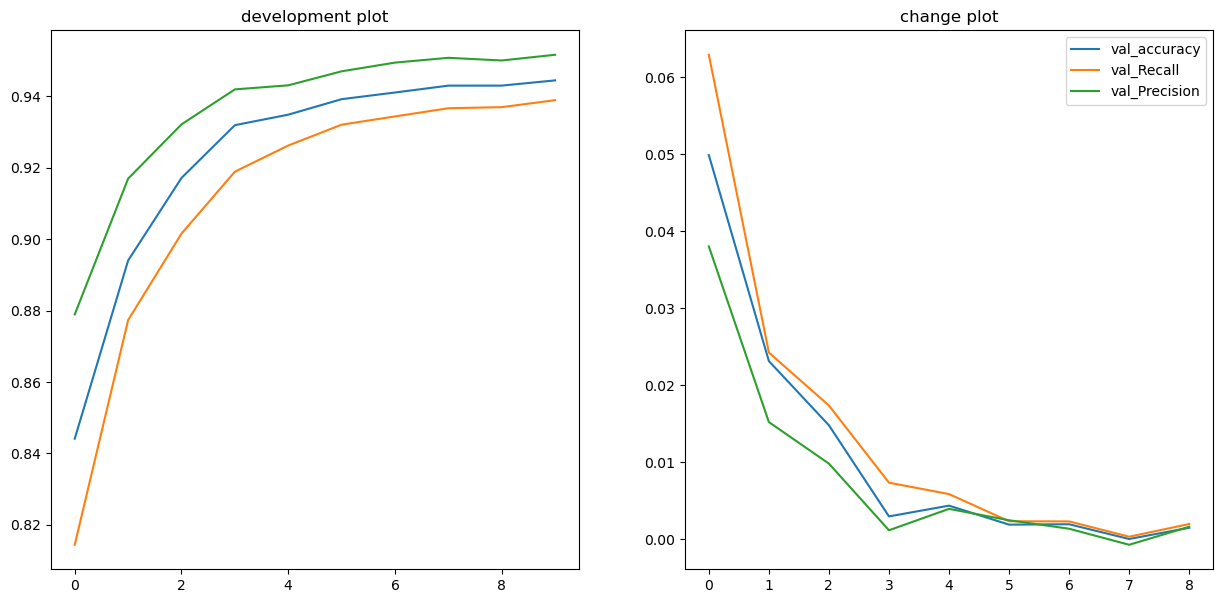

In [16]:
fig, ax = plt.subplots(ncols=2 ,figsize =(15, 7)) 

for metric in history.history.keys():
    if "loss" in metric or 'val' not in metric:
        continue
    data = history.history[metric]
    one = data[:-1]
    two = data[1:]
    ax[0].set_title('development plot')
    ax[0].plot(data, label=metric)
    ax[1].set_title('change plot')
    ax[1].plot(np.array(two)-np.array(one) , label=metric)
    
#plt.ylim(0, 15)
plt.legend()
plt.show()

In [21]:
#evaluation_data = features.iloc[::1000]
#evaluation_label = lables.iloc[::1000]

amount = 100
indize = np.linspace(0,len(val_features)-1, num=amount, dtype=int)

evaluation_data = val_features.iloc[indize]
evaluation_label = val_lables.iloc[indize]

evaluation_predictions = model.predict(evaluation_data)

#print("Prediction:\t {}".format(tf.math.argmax(evaluation_predictions, axis=1)))
#print("Labels:\t\t {}".format(tf.argmax(evaluation_label.to_numpy(),axis=1)))

cunf_matrix = confusion_matrix(tf.argmax(evaluation_label,axis=1),tf.argmax(evaluation_predictions, axis=1))
print(cunf_matrix)

4/4 [==============================] - 0s 731us/step
[[15  1  0  0  0]
 [ 0 61  1  0  0]
 [ 0  0  1  0  0]
 [ 3  0  0  5  0]
 [ 1  1  0  1 10]]


                 mmsi     timestamp  distance_from_shore  distance_from_port  \
4939137  2.151511e+14  1.405618e+09                  0.0                 0.0   
4944053  2.151511e+14  1.411809e+09                  0.0                 0.0   
4944054  2.151511e+14  1.411810e+09                  0.0                 0.0   
4944055  2.151511e+14  1.411811e+09                  0.0                 0.0   
4944057  2.151511e+14  1.411812e+09                  0.0                 0.0   
4944058  2.151511e+14  1.411813e+09                  0.0                 0.0   
4944059  2.151511e+14  1.411814e+09                  0.0                 0.0   
4944060  2.151511e+14  1.411815e+09                  0.0                 0.0   
4944061  2.151511e+14  1.411816e+09                  0.0                 0.0   
4944062  2.151511e+14  1.411816e+09                  0.0                 0.0   
4944063  2.151511e+14  1.411816e+09                  0.0                 0.0   
4944064  2.151511e+14  1.411817e+09     

/var/folders/gm/pxzh4m3d3xlbcffhxnmwc3jm0000gn/T/ipykernel_15021/1538266917.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


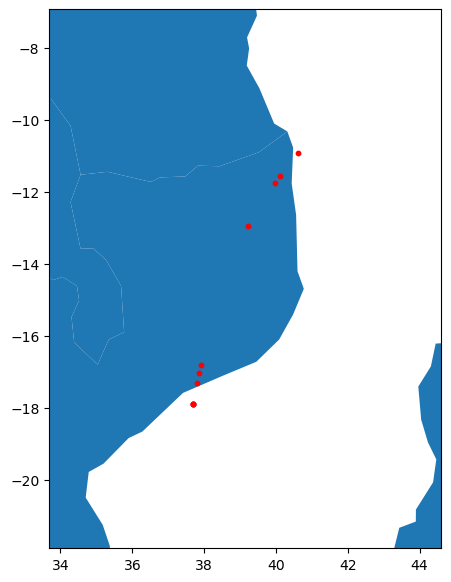

In [121]:
#print(train_features.iloc[0][0])
vesselForPlot = train_features[train_features["mmsi"]==215151145083937.0].sort_values(by=["timestamp"])
print(vesselForPlot.loc[vesselForPlot["distance_from_port"]==0.0])
startTime = 0
endtime = 10
error = 4
vesselForPlot = vesselForPlot.iloc[startTime:endtime+1]

minLat, maxLat = vesselForPlot["lat"].min()-error,vesselForPlot["lat"].max()+error
minLon, maxLon = vesselForPlot["lon"].min()-error,vesselForPlot["lon"].max()+error
print(turnUnixTimeToDate(vesselForPlot.iloc[startTime]["timestamp"]))
print(turnUnixTimeToDate(vesselForPlot.iloc[endtime]["timestamp"]))
 
fig, ax = plt.subplots(figsize=(7,7))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

world.plot(ax=ax)
ax.scatter(x=vesselForPlot["lat"],y=vesselForPlot["lon"],s=10,c="r")

plt.xlim([minLat, maxLat])
plt.ylim([minLon,maxLon])
plt.show()

In [16]:
%tensorboard --logdir logs/fit

print("127.0.0.1:6006")

Launching TensorBoard...

127.0.0.1:6006
